<a href="https://colab.research.google.com/github/rahiakela/deep-learning-research-and-practice/blob/main/%20deep-learning-with-pytorch-lightning/01-pytorch-lightning-basic/01_xor_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##XOR Model

The XOR gate/operator is also known as exclusive OR. It is from a digital logic gate. An
XOR gate is a digital logic gate that produces a true output when it has dissimilar inputs.

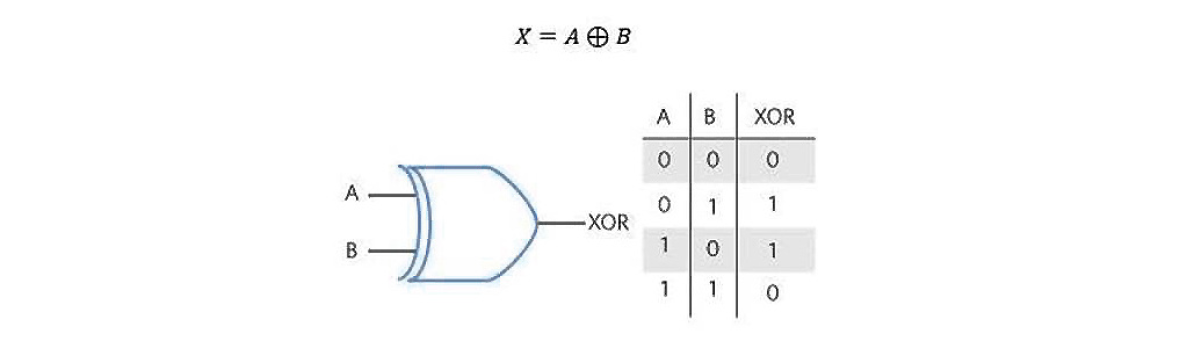

In simple words, an XOR gate is a function that takes two inputs—for example, A and B—and generates a single output.

##Setup

In [ ]:
!pip install pytorch-lightning

In [2]:
import torch
from torch import nn, optim
from torch.autograd import Variable
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from torch.utils.data import DataLoader
from torchmetrics.functional import accuracy

In [3]:
print("torch version:",torch.__version__)
print("pytorch ligthening version:",pl.__version__)

torch version: 1.10.0+cu102
pytorch ligthening version: 1.5.2


##Dataset

In [8]:
xor_input = [
  Variable(torch.Tensor([0, 0])),
  Variable(torch.Tensor([0, 1])),
  Variable(torch.Tensor([1, 0])),
  Variable(torch.Tensor([1, 1]))
]

xor_target = [
  Variable(torch.Tensor([0])),
  Variable(torch.Tensor([1])),
  Variable(torch.Tensor([1])),
  Variable(torch.Tensor([0]))   
]

In [9]:
xor_data = list(zip(xor_input, xor_target))
train_loader = DataLoader(xor_data, batch_size=1000)

##Creating the model

Let's build an XOR NN architecture using the PyTorch Lightning framework.

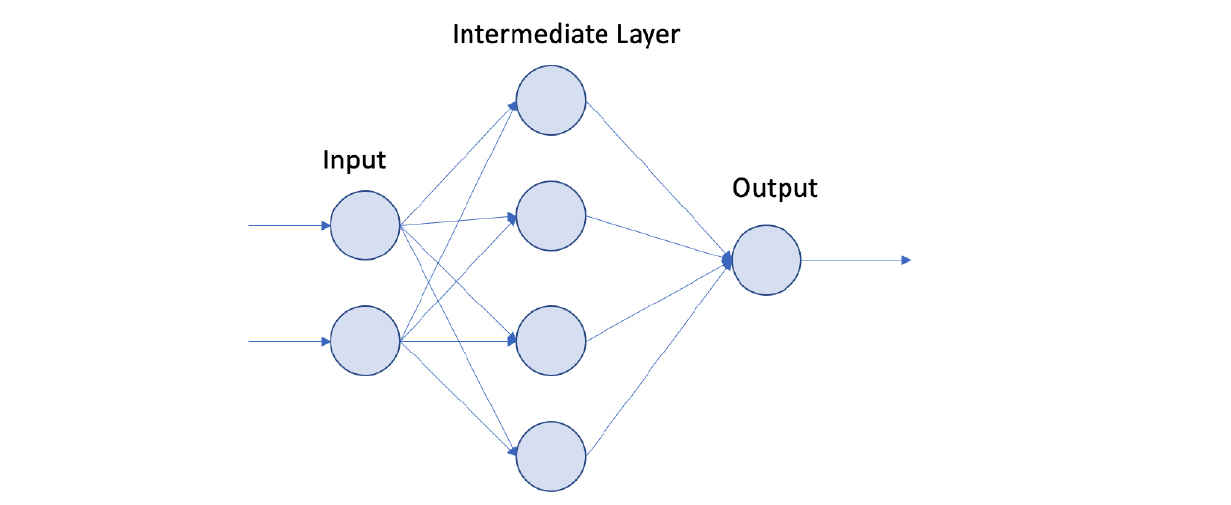

In [10]:
class XORModel(pl.LightningModule):
  def __init__(self):
    super(XORModel, self).__init__()

    self.input_layer = nn.Linear(2, 4)
    self.output_layer = nn.Linear(4, 1)

    self.sigmoid = nn.Sigmoid()
    self.loss = nn.MSELoss()

  def forward(self, input):
    x = self.input_layer(input)
    x = self.sigmoid(x)
    output = self.output_layer(x)
    return output

  def configure_optimizers(self):
    params = self.parameters()
    optimizer = optim.Adam(params=params, lr=0.01)
    return optimizer 

  def training_step(self, batch, batch_idx):
    xor_input, xor_target = batch
    outputs = self(xor_input)
    loss = self.loss(outputs, xor_target)
    return loss

##Training the model

All models built in PyTorch Lightning can be trained using a Trainer class.

In [ ]:
checkpoint_callback = ModelCheckpoint()

model = XORModel()
trainer = pl.Trainer(max_epochs=500, callbacks=[checkpoint_callback])
trainer.fit(model, train_dataloader=train_loader)

Let's look into the log files.

In [12]:
!ls lightning_logs/

version_0  version_1


In [13]:
!ls lightning_logs/*/

lightning_logs/version_0/:
checkpoints  events.out.tfevents.1663053352.c2b211f41b71.263.0	hparams.yaml

lightning_logs/version_1/:
checkpoints  events.out.tfevents.1663053437.c2b211f41b71.263.1	hparams.yaml


##Loading the model

In [14]:
print(checkpoint_callback.best_model_path)

/content/lightning_logs/version_1/checkpoints/epoch=499-step=499.ckpt


In [15]:
trained_model = model.load_from_checkpoint(checkpoint_callback.best_model_path)

##Making predictions

In [16]:
test_data = torch.utils.data.DataLoader(xor_input, batch_size=1)
for x_val in xor_input:
  _ = trained_model(x_val)
  print([int(x_val[0]), int(x_val[1])], int(_.round()))

[0, 0] 0
[0, 1] 1
[1, 0] 1
[1, 1] 0


In [17]:
total_accuracy = []
for xor_input, xor_target in train_loader:
  for i in range(100):
    output_tensor = trained_model(xor_input)
    test_accuracy = accuracy(output_tensor, xor_target.int())
    total_accuracy.append(test_accuracy)

total_accuracy = torch.mean(torch.stack(total_accuracy))
print(f"TOTAL ACCURACY FOR 100 ITERATIONS: {total_accuracy.item()}")

TOTAL ACCURACY FOR 100 ITERATIONS: 1.0
